In [1]:
'''
Homework 8 - skin disease
Name: Austin Ramsey
ID: 000749074
LTU Honor Code: “I have neither given nor received any unauthorized aid in completing this work, nor have I presented someone else's work as my own.”

'''

"\nHomework 8 - skin disease\nName: Austin Ramsey\nID: 000749074\nLTU Honor Code: “I have neither given nor received any unauthorized aid in completing this work, nor have I presented someone else's work as my own.”\n\n"

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, MaxPooling2D, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from scipy.stats import mode

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Directories
train_dir = '/content/drive/MyDrive/DL_data/skin_cancer/train'
validation_dir = '/content/drive/MyDrive/DL_data/skin_cancer/validation'
test_dir = '/content/drive/MyDrive/DL_data/skin_cancer/test'

# For Jupyter Notebook
#train_dir = '/home/robofest/Downloads/skin_cancer/train'
#validation_dir = '/home/robofest/Downloads/skin_cancer/validation'
#test_dir = '/home/robofest/Downloads/skin_cancer/test'


In [31]:
# Image Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=200,
    class_mode='binary',
    shuffle=False)

Found 1852 images belonging to 2 classes.
Found 518 images belonging to 2 classes.
Found 267 images belonging to 2 classes.


In [6]:
# Model 1 using VGG16 as feature extractor
conv_base1 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(299, 299, 3))

# Model 2 using InceptionV3 as feature extractor
conv_base2 = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(299, 299, 3))

# Model 1
model1 = Sequential()
model1.add(conv_base1)
model1.add(GlobalAveragePooling2D())
model1.add(Dense(1024, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

# Model 2
model2 = Sequential()
model2.add(conv_base2)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(1024, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

# Model 3
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)))
model3.add(MaxPooling2D(2, 2))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(2, 2))
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D(2, 2))
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D(2, 2))
model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

# Freeze the convolutional base (pre-trained layers)
conv_base1.trainable = False
conv_base2.trainable = False

# Model Compilation
model1.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])
model2.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])
model3.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Models Summary
model1.summary()
model2.summary()
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 15,241,025
Trainable params: 526,337
Non-trainable params: 14,714,688
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)   

In [7]:
# Callbacks list
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint_vgg16 = ModelCheckpoint('/content/drive/MyDrive/DL_data/skin_cancer/VGG16_Model.h5', monitor='val_loss', save_best_only=True)
model_checkpoint_inceptionv3 = ModelCheckpoint('/content/drive/MyDrive/DL_data/skin_cancer/InceptionV3_Model.h5', monitor='val_loss', save_best_only=True)
model_checkpoint_custom = ModelCheckpoint('/content/drive/MyDrive/DL_data/skin_cancer/Custom_Model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_delta=1e-4, min_lr=1e-6)

callback_list_vgg16 = [early_stopping, model_checkpoint_vgg16, reduce_lr]
callback_list_inceptionv3 = [early_stopping, model_checkpoint_inceptionv3, reduce_lr]
callback_list_custom = [early_stopping, model_checkpoint_custom, reduce_lr]


# Train Models
print('************************')
print('*** INITIAL TRAINING ***')
print('************************\n')

# Train VGG16 Model
print('*** VGG16 Start ***')
history1 = model1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    callbacks=callback_list_vgg16,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)
print('*** VGG16 End ***\n')

# Train InceptionV3 Model
print('*** InceptionV3 Start ***')
history2 = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    callbacks=callback_list_inceptionv3,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)
print('*** InceptionV3 End ***\n')

# Train Custom CNN Model
print('*** Custom CNN Start ***')
history3 = model3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    callbacks=callback_list_custom,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)
print('*** Custom CNN End ***\n')

print('*********************************')
print('*** INITIAL TRAINING COMPLETE ***')
print('***     START FINE-TUNING     ***')
print('*********************************\n')

# Load best weights from initial training
model1.load_weights('/content/drive/MyDrive/DL_data/skin_cancer/VGG16_Model.h5')
model2.load_weights('/content/drive/MyDrive/DL_data/skin_cancer/InceptionV3_Model.h5')

# Unfreeze layers of pre-trained models
for layer in model1.layers[:249]:
    layer.trainable = False
for layer in model1.layers[249:]:
    layer.trainable = True

for layer in model2.layers[:249]:
    layer.trainable = False
for layer in model2.layers[249:]:
    layer.trainable = True

# Compile models
model1.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])
model2.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Fine-tuning VGG16 Model
print('*** VGG16 Fine-tuning Start ***')
history1b = model1.fit(
  train_generator,
  steps_per_epoch=train_generator.samples // train_generator.batch_size,
  epochs=20,
  callbacks=callback_list_vgg16,
  validation_data=validation_generator,
  validation_steps=validation_generator.samples // validation_generator.batch_size
)
print('*** VGG16 Fine-tuning End ***\n')

# Fine-tuning InceptionV3 Model
print('*** InceptionV3 Fine-tuning Start ***')
history2b = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    callbacks=callback_list_inceptionv3,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)
print('*** InceptionV3 Fine-tuning End ***\n')

print('****************************')
print('*** FINE-TUNING COMPLETE ***')
print('****************************')

************************
*** INITIAL TRAINING ***
************************

*** VGG16 Start ***
Epoch 1/30
57/57 [==============================] - 365s 6s/step - loss: 0.6926 - accuracy: 0.5434 - val_loss: 0.6224 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/30
57/57 [==============================] - 54s 950ms/step - loss: 0.6292 - accuracy: 0.6462 - val_loss: 0.5825 - val_accuracy: 0.6504 - lr: 0.0010
Epoch 3/30
57/57 [==============================] - 53s 930ms/step - loss: 0.6007 - accuracy: 0.6786 - val_loss: 0.5881 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 4/30
57/57 [==============================] - 52s 914ms/step - loss: 0.5977 - accuracy: 0.6714 - val_loss: 0.5282 - val_accuracy: 0.7520 - lr: 0.0010
Epoch 5/30
57/57 [==============================] - 56s 982ms/step - loss: 0.5758 - accuracy: 0.6852 - val_loss: 0.5171 - val_accuracy: 0.7539 - lr: 0.0010
Epoch 6/30
57/57 [==============================] - 55s 967ms/step - loss: 0.5628 - accuracy: 0.7110 - val_loss: 0.5178 - val_

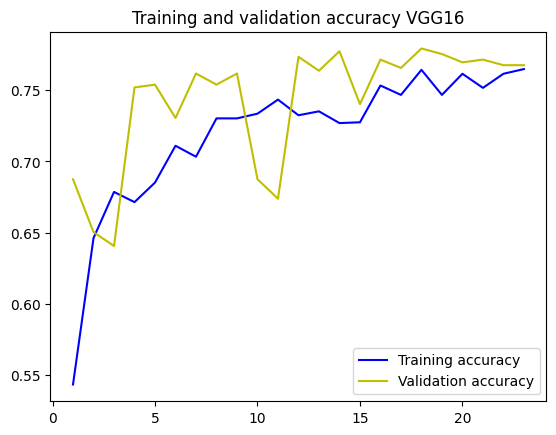

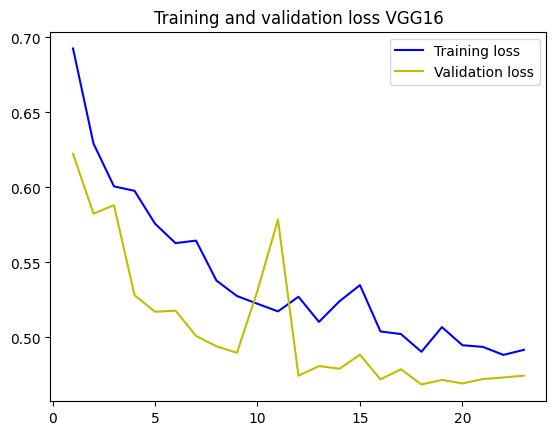

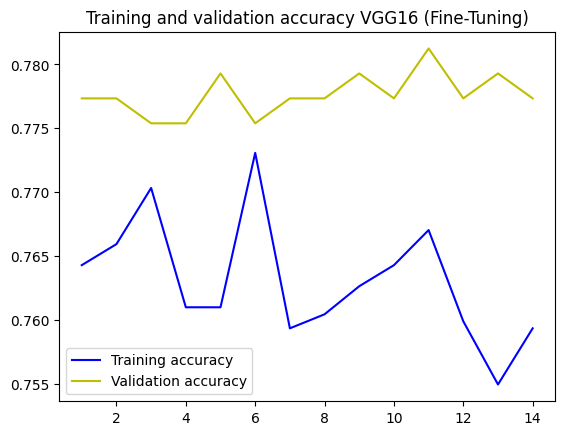

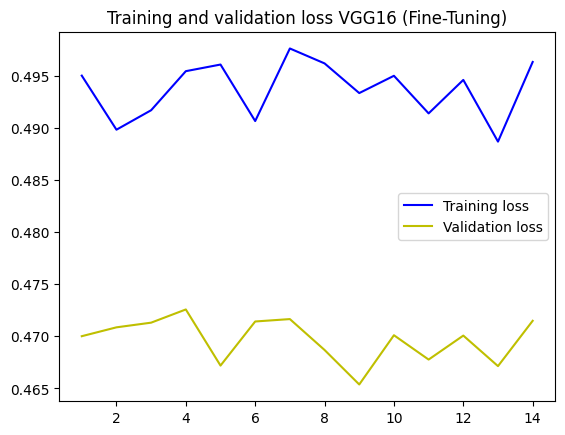

In [8]:
# Plot validation graphs for VGG16
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b-', label='Training accuracy')
plt.plot(epochs, val_acc, 'y-', label='Validation accuracy')
plt.title('Training and validation accuracy VGG16')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'y-', label='Validation loss')
plt.title('Training and validation loss VGG16')
plt.legend()

plt.show()

# Plot fine tuning validation graphs for VGG16
acc = history1b.history['accuracy']
val_acc = history1b.history['val_accuracy']
loss = history1b.history['loss']
val_loss = history1b.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b-', label='Training accuracy')
plt.plot(epochs, val_acc, 'y-', label='Validation accuracy')
plt.title('Training and validation accuracy VGG16 (Fine-Tuning)')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'y-', label='Validation loss')
plt.title('Training and validation loss VGG16 (Fine-Tuning)')
plt.legend()

plt.show()

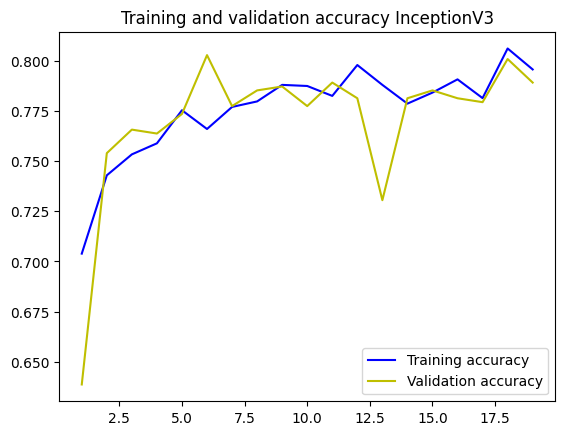

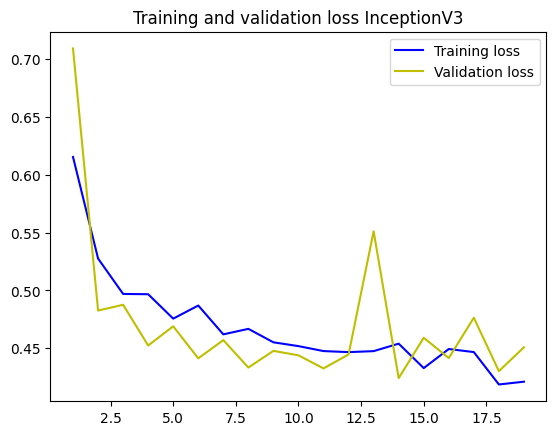

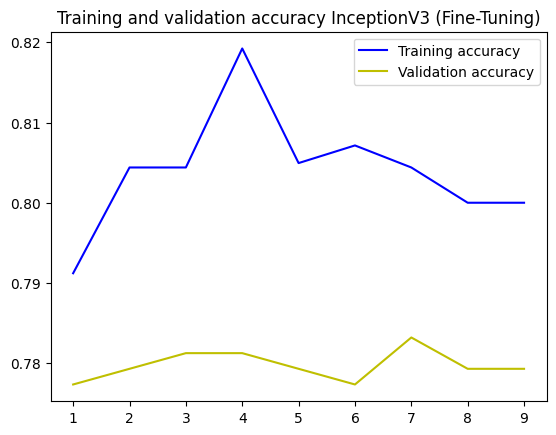

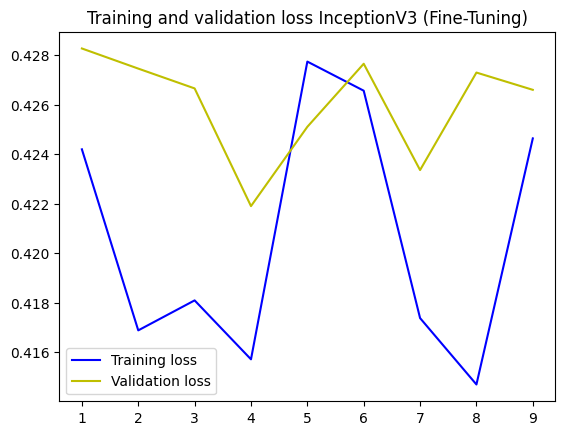

In [9]:
# Plot validation graphs for InceptionV3
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b-', label='Training accuracy')
plt.plot(epochs, val_acc, 'y-', label='Validation accuracy')
plt.title('Training and validation accuracy InceptionV3')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'y-', label='Validation loss')
plt.title('Training and validation loss InceptionV3')
plt.legend()

plt.show()

# Plot fine tuning validation graphs for InceptionV3
acc = history2b.history['accuracy']
val_acc = history2b.history['val_accuracy']
loss = history2b.history['loss']
val_loss = history2b.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b-', label='Training accuracy')
plt.plot(epochs, val_acc, 'y-', label='Validation accuracy')
plt.title('Training and validation accuracy InceptionV3 (Fine-Tuning)')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'y-', label='Validation loss')
plt.title('Training and validation loss InceptionV3 (Fine-Tuning)')
plt.legend()

plt.show()

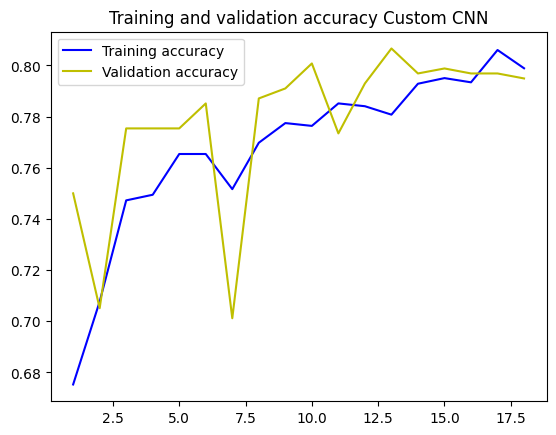

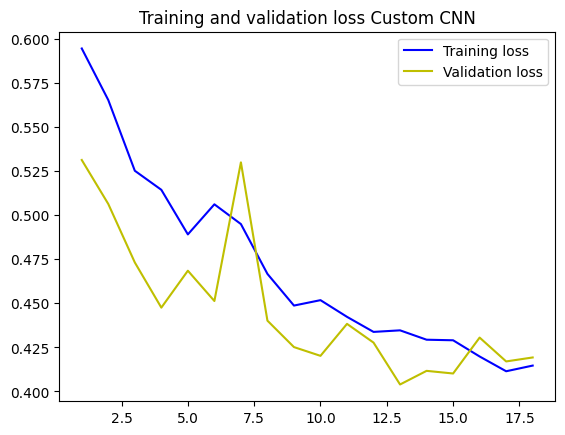

In [11]:
# Plot validation graphs for Custom CNN
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b-', label='Training accuracy')
plt.plot(epochs, val_acc, 'y-', label='Validation accuracy')
plt.title('Training and validation accuracy Custom CNN')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'y-', label='Validation loss')
plt.title('Training and validation loss Custom CNN')
plt.legend()

plt.show()

In [32]:
model1.load_weights('/content/drive/MyDrive/DL_data/skin_cancer/VGG16_Model.h5')
model2.load_weights('/content/drive/MyDrive/DL_data/skin_cancer/InceptionV3_Model.h5')

# Model 1 Evaluation
test_loss1, test_acc1 = model1.evaluate(test_generator)

# Model 2 Evaluation
test_loss2, test_acc2 = model2.evaluate(test_generator)

# Model 3 Evaluation
test_loss3, test_acc3 = model3.evaluate(test_generator)

# Show Accuracy
mean_acc = (test_acc1+test_acc2+test_acc3)/3

print('Mean Accuracy: ', mean_acc*100)

2/2 [==============================] - 6s 1s/step - loss: 0.4684 - accuracy: 0.7566
Mean Accuracy:  76.27965013186136


In [35]:
# Obtain predictions from each model
pred1 = model1.predict(test_generator)
pred2 = model2.predict(test_generator)
pred3 = model3.predict(test_generator)

# Convert predictions to binary class labels
labels1 = np.round(pred1).flatten()
labels2 = np.round(pred2).flatten()
labels3 = np.round(pred3).flatten()

# Perform majority voting
voting_matrix = np.vstack((labels3))
majority_labels, _ = mode(voting_matrix, axis=0)
majority_labels = majority_labels.flatten()

# Calculate ensemble accuracy
true_labels = test_generator.classes

correct_predictions = np.sum(majority_labels == true_labels)
total_predictions = len(true_labels)

ensemble_accuracy = correct_predictions / total_predictions

print('Ensemble test accuracy (majority voting with mode):', ensemble_accuracy)

2/2 [==============================] - 1s 275ms/step
Ensemble test accuracy (majority voting with mode): 0.5243445692883895


<ipython-input-35-e18585789949>:13: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  majority_labels, _ = mode(voting_matrix, axis=0)


1/1 [==============================] - 1s 1s/step


<ipython-input-36-bac808f2d55a>:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  incorrect_indices = np.nonzero(pred_labels != true_labels)[0]


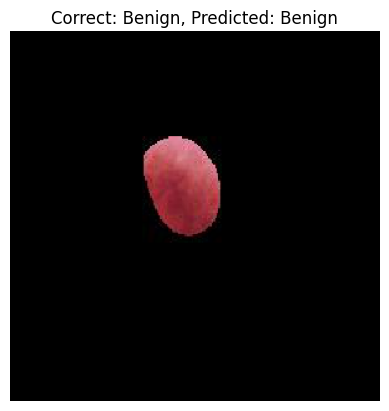

In [36]:
# Display misclassified images
predictions = model3.predict(test_generator, steps=1)
pred_labels = (predictions > 0.5).astype(int).flatten()
true_labels = test_generator.classes
incorrect_indices = np.nonzero(pred_labels != true_labels)[0]

for i, incorrect_index in enumerate(incorrect_indices[:2]):
    img = test_generator[0][0][incorrect_index]
    pred_label = pred_labels[incorrect_index]
    true_label = true_labels[incorrect_index]

    title_text = f"Correct: {'Benign' if true_label == 0 else 'Malignant'}, Predicted: {'Benign' if pred_label == 0 else 'Malignant'}"
    
    plt.figure()
    plt.imshow(img)
    plt.title(title_text)
    plt.axis('off')

plt.show()


In [37]:
# Summarize the results

print(f"The best model 1 test accuracy obtained: {test_acc1*100}%")
print(f"The best model 2 test accuracy obtained: {test_acc2*100}%")
print(f"The best model 3 test accuracy obtained: {test_acc3*100}%")
print(f"The mean test accuracy obtained: {mean_acc*100}%")
print(f"The ensemble test accuracy obtained: {ensemble_accuracy*100}%")

The best model 1 test accuracy obtained: 73.03370833396912%
The best model 2 test accuracy obtained: 80.14981150627136%
The best model 3 test accuracy obtained: 75.65543055534363%
The mean test accuracy obtained: 76.27965013186136%
The ensemble test accuracy obtained: 52.43445692883895%


# Summary/Discussion




I started by using three models in an ensemble using majority voting. The number of epochs used initially was 60, which resulted in accuracy starting around 45% but took far too long to train. I used the MAE history graph and the validation accuracy and loss graphs to determine the range of epochs I needed to use, which ended up around 30 resulting in 80%+ accuracy depending on the models. The graphs for training and validation accuracy and loss can be seen above, as well as the mean test accuracy of 76.27%. Initially I had used another pre-trained network called VGG19 but the total training for all three pre-trained models was too extensive as well, to mitigate training for too long I created a custom cnn model. As well I had to try different batch sizes, data augmentation, and target sizes to get optimal results that didn't take hours to train.